# Transfer Learning With TensorFlow - Part 3: Scaling Up (🍔👁️ Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-turning; now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is the beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

## Creating Helper Functions:

In previous notebooks, we've created a series of helper functions to do different tasks; let's download them.

In [1]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes - Working With Less Data:

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

In [7]:
# How many images/classes are there?
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [3]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                shuffle = False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train A Big Dog Model With Transfer Learning On 10% Of 101 Food Classes:

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetV2B0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [10]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint.weights.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = 'val_accuracy',
                                                         save_best_only = True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Set up data augmentation
data_augmentation = Sequential([
    layers.Input(shape = (224, 224, 3)), #Remember that the input layer/shape is now explicitly stated at the top of the model!
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # layers.Rescaling(1/255.) # Rescale inputs of images to between 0 & 1; required for models like ResNet50
], name = 'data_augmentation')

In [13]:
# Set up the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Set up model architecture with trainable top layers
inputs = layers.Input(shape = (224, 224, 3), name = 'input_layer')
x = data_augmentation(inputs) # Augment images (only happens during training phase)
x = base_model(x, training = False) # Put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name = 'global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
# Get a summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [15]:
# Compile
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5, # Fit for 5 epochs to keep experiments quick
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)), # Validate on only 15% of test data during training
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 877s 4s/step - accuracy: 0.1304 - loss: 4.0981 - val_accuracy: 0.3946 - val_loss: 2.7845
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 817s 3s/step - accuracy: 0.4192 - loss: 2.5775 - val_accuracy: 0.4942 - val_loss: 2.2071
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 817s 3s/step - accuracy: 0.4916 - loss: 2.1867 - val_accuracy: 0.5103 - val_loss: 2.0226
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 807s 3s/step - accuracy: 0.5274 - loss: 1.9552 - val_accuracy: 0.5193 - val_loss: 1.9084
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 810s 3s/step - accuracy: 0.5616 - loss: 1.7896 - val_accuracy: 0.5403 - val_loss: 1.8247


In [16]:
#Save model and its history
import numpy as np
model.save('101_classes_10_percent_feature_extraction.keras')
np.save('history_all_classes_10_percent_feature_extraction.npy', history_all_classes_10_percent)

In [42]:
#Load model and its history
model = tf.keras.models.load_model('101_classes_10_percent_feature_extraction.keras')
history_all_classes_10_percent = np.load('history_all_classes_10_percent_feature_extraction.npy', allow_pickle = True).item()

In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 2225s 3s/step - accuracy: 0.5525 - loss: 1.7474


[1.6473592519760132, 0.573623776435852]

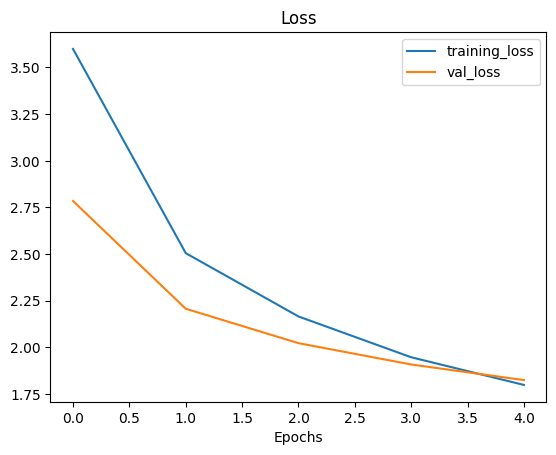

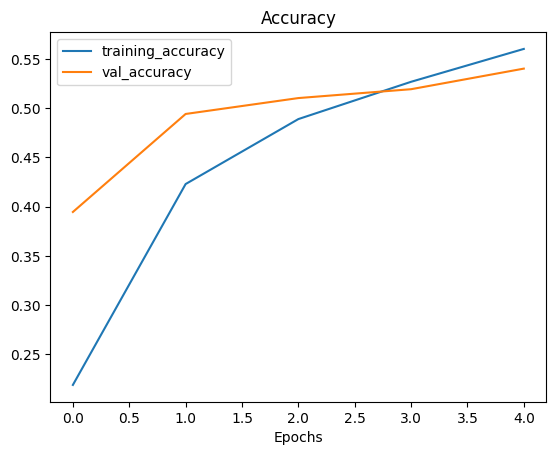

In [19]:
plot_loss_curves(history_all_classes_10_percent)

🤔 **Question:** What do these curves suggest? Hint: Ideally, the two curves should be very similar to each other; if not, it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unzeen data).

## Fine-Tuning:

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False
#If you save and reload models too much, you may have to go directly to the loaded model's sublayer rather than the base model

In [ ]:
# Unfreeze all of the layers in the base model
model.layers[2].trainable = True

# Refreeze every layer except the last 5
for layer in model.layers[2].layers[:-5]:
    layer.trainable = False

In [44]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # Learning rate lowered by 10x
              metrics = ['accuracy'])

In [45]:
# What layers in the model are trainable?
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_avg_pool_layer True
output_layer True


In [46]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv

In [47]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # Model has already done 5 epochs (feature extraction); this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 1157s 5s/step - accuracy: 0.5610 - loss: 1.9354 - val_accuracy: 0.5132 - val_loss: 1.9809
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 859s 4s/step - accuracy: 0.6030 - loss: 1.7614 - val_accuracy: 0.5310 - val_loss: 1.8854
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 633s 3s/step - accuracy: 0.6026 - loss: 1.6892 - val_accuracy: 0.5347 - val_loss: 1.8199
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 638s 3s/step - accuracy: 0.6215 - loss: 1.6089 - val_accuracy: 0.5535 - val_loss: 1.7537
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 651s 3s/step - accuracy: 0.6295 - loss: 1.5696 - val_accuracy: 0.5546 - val_loss: 1.7331
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 629s 3s/step - accuracy: 0.6350 - loss: 1.5097 - val_accuracy: 0.5575 - val_loss: 1.7011


In [48]:
#Save model and its hstory
model.save('101_classes_10_percent_fine_tune.keras')
np.save('history_all_classes_10_percent_fine_tune.npy', history_all_classes_10_percent_fine_tune)

In [49]:
#Load model and its history
model = tf.keras.models.load_model('101_classes_10_percent_fine_tune.keras')
history_all_classes_10_percent_fine_tune = np.load('history_all_classes_10_percent_fine_tune.npy', allow_pickle = True).item()

In [50]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 1609s 2s/step - accuracy: 0.5786 - loss: 1.5983


[1.4813401699066162, 0.6063366532325745]

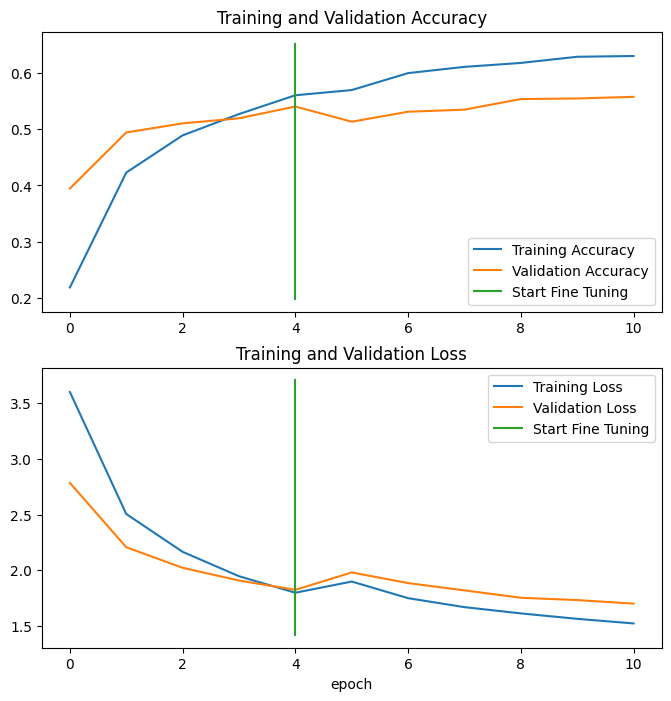

In [51]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Saving And Loading Our Model:

To use our model in an external application, we'll need to save it and export it somewhere.

In [52]:
# Save our fine-tuning model
model.save('101_food_classes_10_percent_saved_big_dog_model.keras')

🔑 **Note:** Loading the model with the following cell will output a large amount of warnings; there is a thread tracking this issue on GitHub: https://github.com/tensorflow/tensorflow/issues/40166, however, it seems according to the TensorFlow documentation, loading warnings can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_usage

In [53]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model('101_food_classes_10_percent_saved_big_dog_model.keras')

In [54]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 1545s 2s/step - accuracy: 0.5786 - loss: 1.5983


[1.4813401699066162, 0.6063366532325745]

In [55]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.4813401699066162, 0.6063366532325745]

## Evaluating The Performance Of The Big Dog Model Across All Different Classes:

Let's make some predictions, visualize them, and then later find out which predictions were the "most" wrong.

In [4]:
import tensorflow as tf

# Download pretrained model (one that was perpared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [58]:
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [ ]:
# Load in saved model
model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')
#The model provided is too old to be loaded with tf.keras.models.load_model(); in order to load it, you have to use a special legacy model loader (tf.saved_model.load())

ValueError: File format not supported: filepath=06_101_food_class_10_percent_saved_big_dog_model. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(06_101_food_class_10_percent_saved_big_dog_model, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [ ]:
import keras
model = tf.saved_model.load('06_101_food_class_10_percent_saved_big_dog_model')
#This doesn't even work anymore since you can't even work with legacy models in Keras 3. Reverting to your model...

In [7]:
model = tf.keras.models.load_model('101_food_classes_10_percent_saved_big_dog_model.keras')

In [8]:
# Evaluate loaded model (the one we just dowloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 2513s 3s/step - accuracy: 0.5786 - loss: 1.5983


[1.4813401699066162, 0.6063366532325745]

## Making Predictions With Our Trained Model:

In [9]:
# Make predictions with our model
pred_probs = model.predict(test_data, verbose = 1) # Set verbosity to see how long is left

790/790 ━━━━━━━━━━━━━━━━━━━━ 2414s 3s/step


In [12]:
#Save prediction probabilities
np.save('pred_probs.npy', pred_probs)

In [13]:
#Load prediction probabilities
pred_probs = np.load('pred_probs.npy')

In [14]:
len(test_data)

790

In [15]:
790 * 32

25280

In [16]:
# How many predictions are there?
len(pred_probs)

25250

In [17]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [18]:
# Let's see what the first 10 predictions look like
pred_probs[:10]

array([[4.0179230e-03, 5.8617676e-04, 1.1786128e-01, ..., 5.2986870e-05,
        4.4550509e-03, 6.2661566e-04],
       [4.7332662e-01, 2.3793931e-05, 1.2427579e-02, ..., 1.3419722e-03,
        1.2550334e-04, 1.5995878e-03],
       [1.7611413e-01, 4.9213873e-04, 2.5962729e-02, ..., 4.2583481e-03,
        1.2504508e-03, 2.8280383e-03],
       ...,
       [2.5790173e-01, 2.5737705e-05, 5.4181896e-02, ..., 1.8169540e-03,
        1.0841886e-03, 1.8416865e-03],
       [1.1490396e-01, 3.0470881e-04, 1.6318017e-01, ..., 4.7100149e-03,
        3.1459259e-04, 1.0965625e-03],
       [2.0380850e-01, 1.2053502e-05, 1.8190730e-02, ..., 3.9319182e-03,
        1.0494285e-04, 1.6791439e-03]], dtype=float32)

In [19]:
# What does the first prediction probability array look like?
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([4.0179230e-03, 5.8617676e-04, 1.1786128e-01, 9.0982503e-06,
        3.0413669e-04, 1.7309631e-03, 3.2827581e-04, 1.8075654e-04,
        1.7891410e-03, 6.3709477e-03, 2.0792359e-04, 3.0508300e-04,
        1.4344761e-03, 3.2741585e-04, 2.3444733e-02, 2.1047013e-02,
        2.5023352e-03, 2.6446758e-03, 1.0064437e-02, 3.6849570e-03,
        6.6115377e-03, 1.0807434e-04, 4.5220656e-04, 3.2679801e-04,
        1.3103473e-03, 1.2003851e-02, 7.1291649e-03, 2.4094853e-04,
        2.9009197e-02, 6.4419210e-04, 1.0795026e-04, 4.3633551e-04,
        1.7299091e-02, 8.4406161e-04, 1.6316123e-02, 2.0482167e-04,
        2.3291609e-03, 3.4853388e-03, 2.0411607e-02, 5.7136733e-04,
        2.8308334e-03, 4.1206651e-03, 8.6416566e-04, 1.3063826e-03,
        1.4792210e-03, 6.0157361e-04, 1.7932365e-03, 6.3975004e-04,
        7.0712884e-04, 3.9446283e-02, 3.0788893e-03, 3.6814727e-03,
        4.8797071e-02, 5.0318863e-02, 1.4139838e-04, 3.8670497e-03,
        8.1614256e-03, 3.3552591e-03, 6.7333970e

Our model outputs a prediction probability array (with N number of variables where N is the number of classes) for each sample passed to the predict method.

In [20]:
# We get one prediction probability per class (in our case, there's 101 prediction probabilities)
print(f'Number of prediction probabilities for samples 0: {len(pred_probs[0])}')
print(f'What prediction probability sample 0 looke like:\n {pred_probs[0]}')
print(f'The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}')

Number of prediction probabilities for samples 0: 101
What prediction probability sample 0 looke like:
 [4.0179230e-03 5.8617676e-04 1.1786128e-01 9.0982503e-06 3.0413669e-04
 1.7309631e-03 3.2827581e-04 1.8075654e-04 1.7891410e-03 6.3709477e-03
 2.0792359e-04 3.0508300e-04 1.4344761e-03 3.2741585e-04 2.3444733e-02
 2.1047013e-02 2.5023352e-03 2.6446758e-03 1.0064437e-02 3.6849570e-03
 6.6115377e-03 1.0807434e-04 4.5220656e-04 3.2679801e-04 1.3103473e-03
 1.2003851e-02 7.1291649e-03 2.4094853e-04 2.9009197e-02 6.4419210e-04
 1.0795026e-04 4.3633551e-04 1.7299091e-02 8.4406161e-04 1.6316123e-02
 2.0482167e-04 2.3291609e-03 3.4853388e-03 2.0411607e-02 5.7136733e-04
 2.8308334e-03 4.1206651e-03 8.6416566e-04 1.3063826e-03 1.4792210e-03
 6.0157361e-04 1.7932365e-03 6.3975004e-04 7.0712884e-04 3.9446283e-02
 3.0788893e-03 3.6814727e-03 4.8797071e-02 5.0318863e-02 1.4139838e-04
 3.8670497e-03 8.1614256e-03 3.3552591e-03 6.7333970e-03 2.7601945e-04
 4.9140137e-05 2.6072359e-03 9.3279816e-03 9

In [21]:
test_data.class_names[85]

'samosa'

In [22]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis = 1)

# How do they look?
pred_classes[:10]

array([85,  0,  0,  0,  8, 78, 29, 46,  2, 41])

In [23]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions; to evaluate ethem, we need to compare them to the original test dataset labels.

In [24]:
# To get our test labels, we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # Currently test labels look like: [0, 0, 0, 1, ... 0, 0]; we want the index value where the "1" occurs
y_labels[:10] # Look at the first 10

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

In [25]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating Our Model's Predictions:

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [26]:
results_downloaded_model

[1.4813401699066162, 0.6063366532325745]

In [27]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)
sklearn_accuracy

0.6063366336633663

In [28]:
# Does this metric come close to our model's evaluate result
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

np.True_

## Let's Get Visual - Making A Confusion Matrix:

In [29]:
from helper_functions import make_confusion_matrix

In [30]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [31]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation = 90, fontsize = text_size)
  plt.yticks(fontsize = text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [32]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100, 100),
                      text_size = 20,
                      savefig = True)

## Let's Keep The Evaluation Train Going - Time For A Classification Report:

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall, and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html); let's try it out.

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.34      0.12      0.18       250
           1       0.59      0.67      0.63       250
           2       0.65      0.55      0.59       250
           3       0.70      0.57      0.63       250
           4       0.57      0.45      0.50       250
           5       0.61      0.38      0.47       250
           6       0.71      0.78      0.75       250
           7       0.84      0.72      0.78       250
           8       0.32      0.50      0.39       250
           9       0.36      0.77      0.49       250
          10       0.55      0.46      0.50       250
          11       0.53      0.62      0.57       250
          12       0.79      0.55      0.65       250
          13       0.60      0.58      0.59       250
          14       0.46      0.67      0.55       250
          15       0.42      0.29      0.34       250
          16       0.67      0.48      0.56       250
          17       0.52    

The numbers above give a great class-by-class evaluation of our model's predic tions, but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [34]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict = True)
classification_report_dict

{'0': {'precision': 0.33695652173913043,
  'recall': 0.124,
  'f1-score': 0.18128654970760233,
  'support': 250.0},
 '1': {'precision': 0.5936395759717314,
  'recall': 0.672,
  'f1-score': 0.6303939962476548,
  'support': 250.0},
 '2': {'precision': 0.6492890995260664,
  'recall': 0.548,
  'f1-score': 0.5943600867678959,
  'support': 250.0},
 '3': {'precision': 0.696078431372549,
  'recall': 0.568,
  'f1-score': 0.6255506607929515,
  'support': 250.0},
 '4': {'precision': 0.5707070707070707,
  'recall': 0.452,
  'f1-score': 0.5044642857142857,
  'support': 250.0},
 '5': {'precision': 0.6114649681528662,
  'recall': 0.384,
  'f1-score': 0.47174447174447176,
  'support': 250.0},
 '6': {'precision': 0.7142857142857143,
  'recall': 0.78,
  'f1-score': 0.745697896749522,
  'support': 250.0},
 '7': {'precision': 0.8418604651162791,
  'recall': 0.724,
  'f1-score': 0.7784946236559139,
  'support': 250.0},
 '8': {'precision': 0.32142857142857145,
  'recall': 0.504,
  'f1-score': 0.392523364485

In [35]:
classification_report_dict['99']['f1-score']

0.34080717488789236

Let's plot all of our classes' F1-scores...

In [36]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    if k == 'accuracy': # Stop once we get to accuracy key
        break
    else:
        # Add class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.18128654970760233,
 'baby_back_ribs': 0.6303939962476548,
 'baklava': 0.5943600867678959,
 'beef_carpaccio': 0.6255506607929515,
 'beef_tartare': 0.5044642857142857,
 'beet_salad': 0.47174447174447176,
 'beignets': 0.745697896749522,
 'bibimbap': 0.7784946236559139,
 'bread_pudding': 0.3925233644859813,
 'breakfast_burrito': 0.4897959183673469,
 'bruschetta': 0.49891540130151846,
 'caesar_salad': 0.5724770642201835,
 'cannoli': 0.6462264150943396,
 'caprese_salad': 0.5853658536585366,
 'carrot_cake': 0.5475409836065573,
 'ceviche': 0.3443396226415094,
 'cheese_plate': 0.5560747663551402,
 'cheesecake': 0.4474885844748858,
 'chicken_curry': 0.48148148148148145,
 'chicken_quesadilla': 0.5924453280318092,
 'chicken_wings': 0.7083333333333334,
 'chocolate_cake': 0.5731462925851704,
 'chocolate_mousse': 0.4212678936605317,
 'churros': 0.7280898876404495,
 'clam_chowder': 0.7397260273972602,
 'club_sandwich': 0.6240601503759399,
 'crab_cakes': 0.4246987951807229,
 'creme_brul

In [37]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending = False)

In [38]:
f1_scores

class_names  f1-score
33            edamame  0.955513
63           macarons  0.880694
75                pho  0.857692
69            oysters  0.842553
54  hot_and_sour_soup  0.842505
..                ...       ...
99       tuna_tartare  0.340807
82            ravioli  0.336449
77          pork_chop  0.274112
39          foie_gras  0.225434
0           apple_pie  0.181287

[101 rows x 2 columns]

In [39]:
f1_scores[:10]

class_names  f1-score
33            edamame  0.955513
63           macarons  0.880694
75                pho  0.857692
69            oysters  0.842553
54  hot_and_sour_soup  0.842505
65            mussels  0.838574
45      frozen_yogurt  0.837945
86            sashimi  0.830266
88      seaweed_salad  0.819383
32          dumplings  0.809793

In [40]:
f1_scores[-10:]

class_names  f1-score
8   bread_pudding  0.392523
87       scallops  0.377734
37   filet_mignon  0.365385
93          steak  0.353167
15        ceviche  0.344340
99   tuna_tartare  0.340807
82        ravioli  0.336449
77      pork_chop  0.274112
39      foie_gras  0.225434
0       apple_pie  0.181287

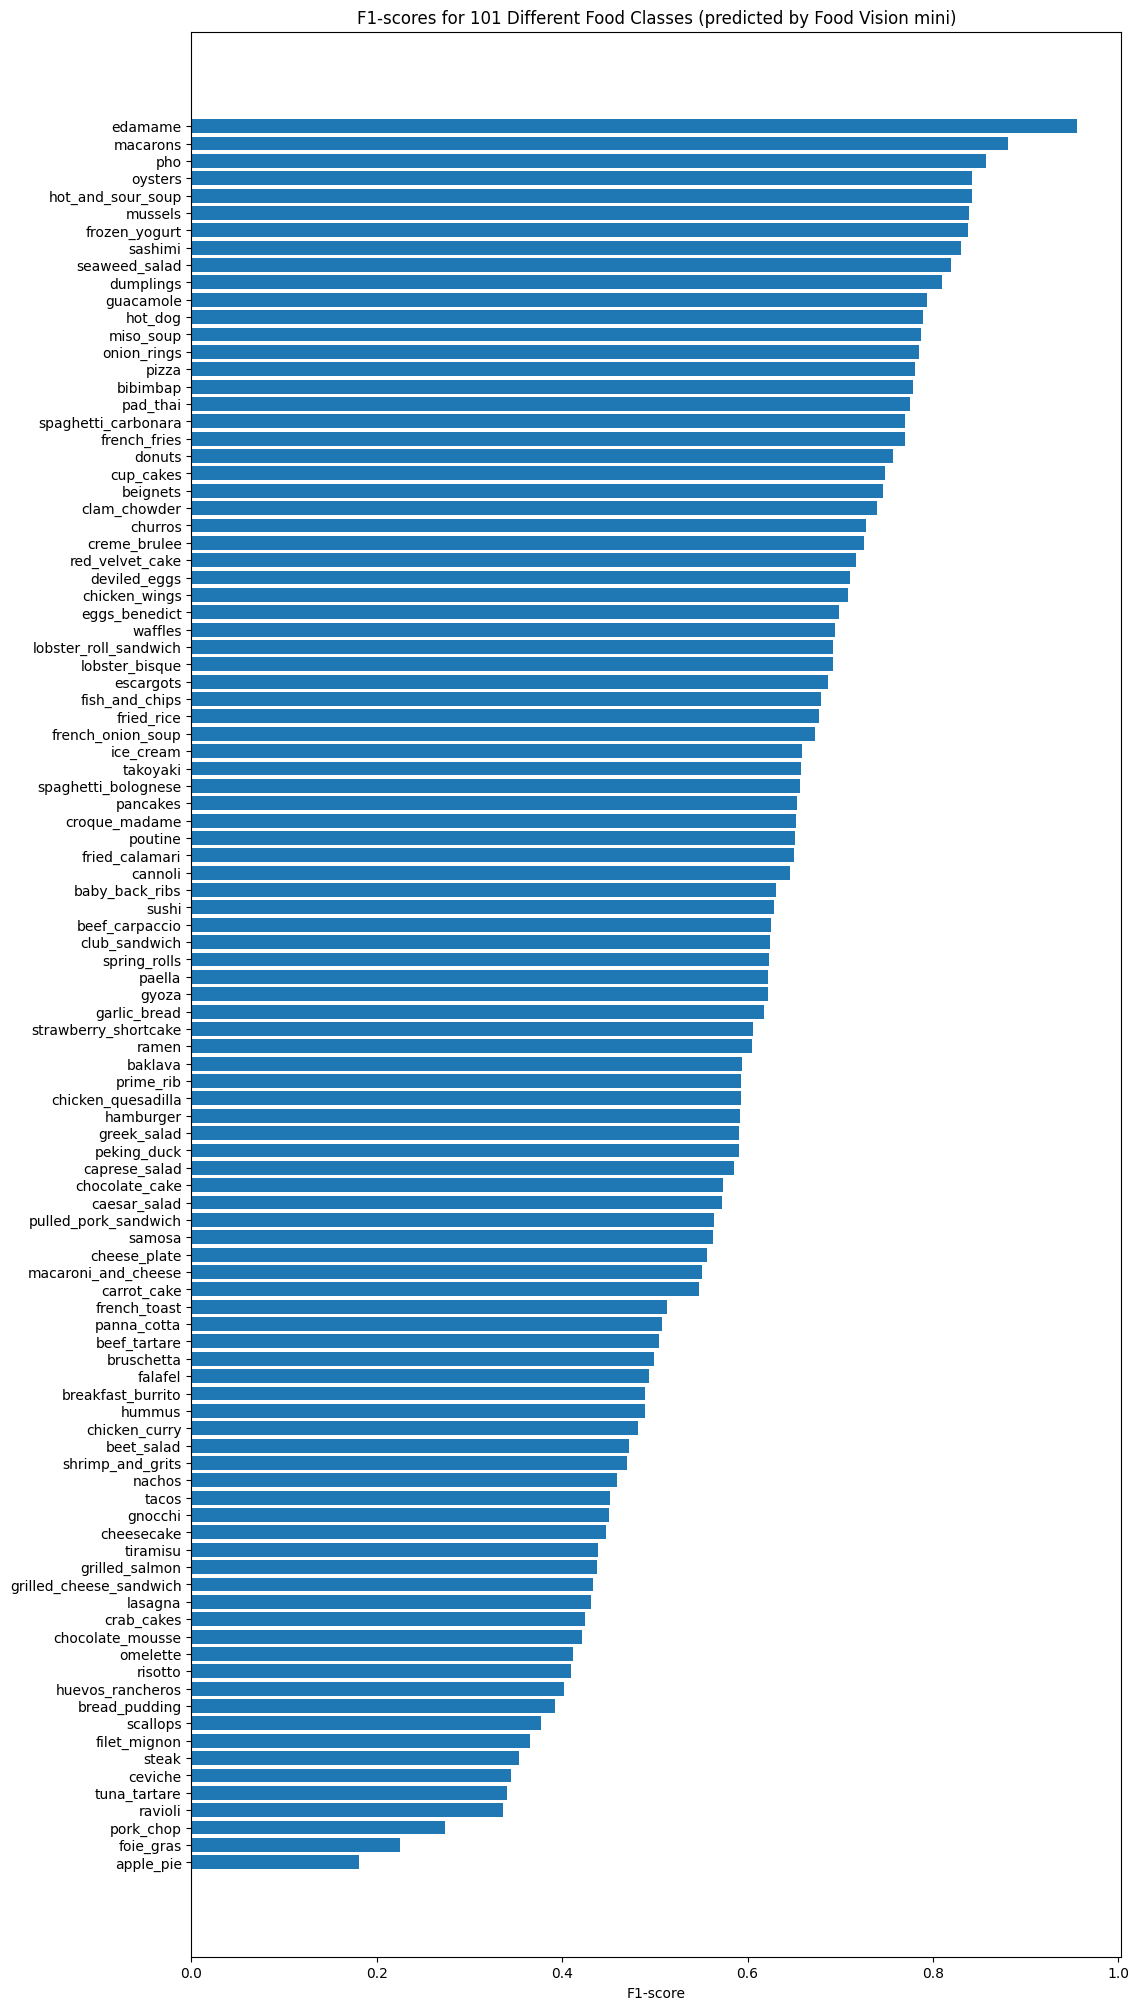

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values) # Get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1-score')
ax.set_title('F1-scores for 101 Different Food Classes (predicted by Food Vision mini)')
ax.invert_yaxis(); # Reverse the order of our plot

# Challenge: Add values to the end of each bar of what the actual f1-score is
#(hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html)

🛠️ **Exercise:** Try visualizing some of the most poorly predicted classes (e.g. `apple_pie`, `pork_chop`); do you notice any trends among them? Why might our model be having trouble with them?

## Visualizing Predictions On Test Images:

Now, this is the real test; how does our model go on food images not even in our test dataset (images of our own, we'll see this later on)?

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images; specifically, it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [42]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape = 224, scale = True):
    """
    Reads in an image from filename, turns it into a tensor, and reshapes it into a specified shape (img_shape, img_shape, color_channels = 3).

    Args:
        filename (str): Path to target image
        image_shape (int): Height.width dimension of target image size
        scale (bool): Whether to scale pizel values from 0-255 to 0-1 or not
    
    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    """
    # Read in the image
    img = tf.io.read_file(filename)

    # Decode image into tensor
    img = tf.io.decode_image(img, channels = 3)

    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])

    # Scale? Yes/no
    if scale:
        # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img # Don't need to rescale images for EfficientNet models in TensorFlow

Now that we've got a function to load and prepare target images, let's now write some code to visualize images, their target label, and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability, and truth label

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


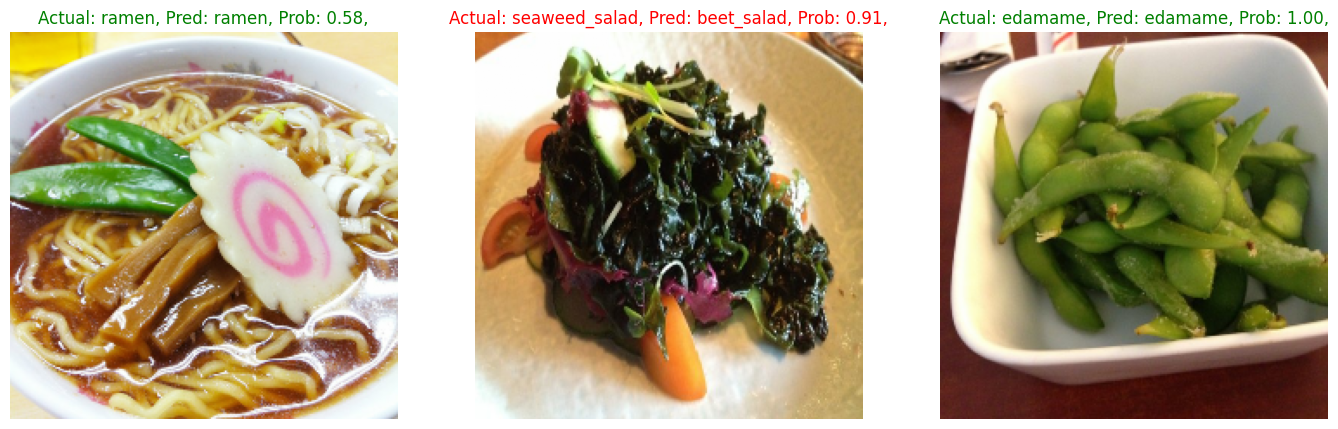

In [45]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize = (17, 10))
for i in range(3):
    # Choose a random image from random class(es)
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + '/' + class_name))
    filepath = test_dir + class_name + '/' + filename
    
    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale = False)
    #print(img.shape)
    img_expanded = tf.expand_dims(img, axis = 0)
    #print(img_expanded.shape)
    pred_prob = model.predict(img_expanded) # Get prediction probabilities array
    pred_class = class_names[pred_prob.argmax()] # Get highest prediction probability index and match it to class_names list
    #print(pred_prob)
    #print(pred_class)

    # Plot the image(s)
    plt.subplot(1, 3, i + 1)
    #print(img)
    plt.imshow(img/255.)
    if class_name == pred_class: # If predicted class matches truth class, make text green
        title_color = 'g'
    else:
        title_color = 'r'
    plt.title(f'Actual: {class_name}, Pred: {pred_class}, Prob: {pred_prob.max():.2f},', c = title_color)
    plt.axis(False);

## Finding The Most Wrong Predictions:

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using the [list_files()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method.
2. Create a Pandas DataFrame of the image file paths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, and ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities, but have the wrong prediction.

In [46]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files('101_food_classes_10_percent/test/*/*.jpg', shuffle = False):
    filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [48]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'y_pred': pred_classes,
                        'pred_conf': pred_probs.max(axis = 1), # Get the maximum prediction probability value
                        'y_true_classname': [class_names[i] for i in y_labels],
                        'y_pred_classname': [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent\\test\\apple_pie...       0      85   
1      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
4      b'101_food_classes_10_percent\\test\\apple_pie...       0       8   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25246  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25247  b'101_food_classes_10_percent\\test\\waffles\\...     100      56   
25248  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25249  b'101_food_classes_10_percent\\test\\waffles\\...     100      52   

       pred_conf y_true_classname  y_pred_classname  
0       0.320295        apple_pie            samosa  
1       0.473327        apple_pie         apple_pie  
2       0.176114        apple_pie         apple_pie  
3       0.337685        apple_pie         apple_pie  
4       0.724342        apple_pie     bread_pudding  
...          ...              ...               ...  
25245   0.793408          waffles           waffles  
25246   0.935069          waffles           waffles  
25247   0.544331          waffles  huevos_rancheros  
25248   0.274174          waffles           waffles  
25249   0.257966          waffles             gyoza  

[25250 rows x 6 columns]

In [49]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0      85   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.320295        apple_pie           samosa         False  
1   0.473327        apple_pie        apple_pie          True  
2   0.176114        apple_pie        apple_pie          True  
3   0.337685        apple_pie        apple_pie          True  
4   0.724342        apple_pie    bread_pudding         False

In [50]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf', ascending = False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
18001  b'101_food_classes_10_percent\\test\\pancakes\...      72      67   
14482  b'101_food_classes_10_percent\\test\\hummus\\8...      57      51   
5114   b'101_food_classes_10_percent\\test\\chicken_w...      20      38   
23797  b'101_food_classes_10_percent\\test\\sushi\\16...      95      86   
9690   b'101_food_classes_10_percent\\test\\fish_and_...      38      20   
17897  b'101_food_classes_10_percent\\test\\paella\\2...      71      65   
21400  b'101_food_classes_10_percent\\test\\samosa\\3...      85      92   
4836   b'101_food_classes_10_percent\\test\\chicken_q...      19       9   
14062  b'101_food_classes_10_percent\\test\\huevos_ra...      56      28   
18541  b'101_food_classes_10_percent\\test\\peking_du...      74      85   
9402   b'101_food_classes_10_percent\\test\\filet_mig...      37      79   
23992  b'101_food_classes_10_percent\\test\\sushi\\91...      95      86   
605    b'101_food_classes_10_percent\\test\\baklava\\...       2      53   
17908  b'101_food_classes_10_percent\\test\\paella\\3...      71      65   
21192  b'101_food_classes_10_percent\\test\\risotto\\...      84      51   
4683   b'101_food_classes_10_percent\\test\\chicken_c...      18      81   
20191  b'101_food_classes_10_percent\\test\\pulled_po...      80       9   
20067  b'101_food_classes_10_percent\\test\\pulled_po...      80      53   
5880   b'101_food_classes_10_percent\\test\\churros\\...      23      68   
8971   b'101_food_classes_10_percent\\test\\escargots...      35      41   

       pred_conf      y_true_classname   y_pred_classname  pred_correct  
18001   0.984853              pancakes           omelette         False  
14482   0.982901                hummus          guacamole         False  
5114    0.978430         chicken_wings     fish_and_chips         False  
23797   0.977978                 sushi            sashimi         False  
9690    0.977225        fish_and_chips      chicken_wings         False  
17897   0.974116                paella            mussels         False  
21400   0.969806                samosa       spring_rolls         False  
4836    0.969692    chicken_quesadilla  breakfast_burrito         False  
14062   0.968344      huevos_rancheros      croque_madame         False  
18541   0.967024           peking_duck             samosa         False  
9402    0.966637          filet_mignon          prime_rib         False  
23992   0.965814                 sushi            sashimi         False  
605     0.964629               baklava          hamburger         False  
17908   0.959674                paella            mussels         False  
21192   0.958596               risotto          guacamole         False  
4683    0.952773         chicken_curry              ramen         False  
20191   0.951429  pulled_pork_sandwich  breakfast_burrito         False  
20067   0.950388  pulled_pork_sandwich          hamburger         False  
5880    0.948211               churros        onion_rings         False  
8971    0.948162             escargots  french_onion_soup         False

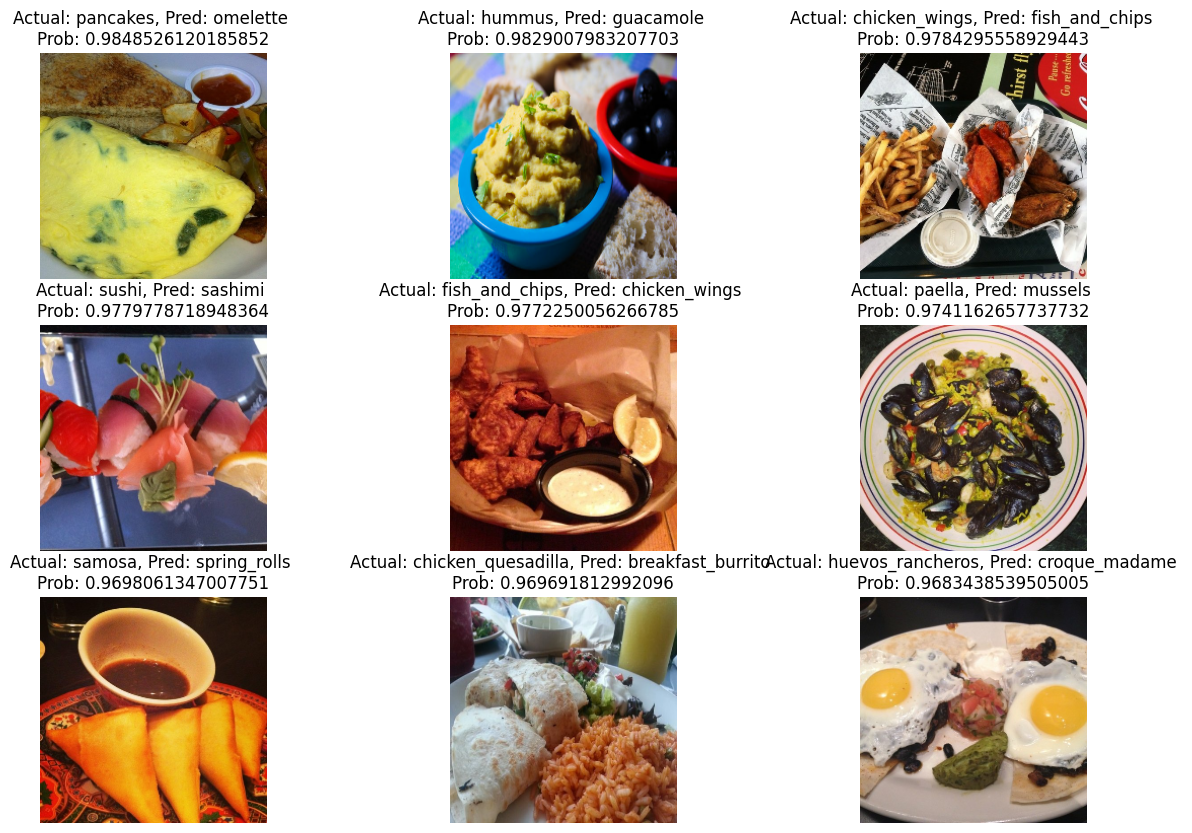

In [53]:
# 5. Visualize the test data samples which have the wrong prediction, but highest pred probability
images_to_view = 9
start_index = 0
plt.figure(figsize = (15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index + images_to_view].itertuples()):
    plt.subplot(3, 3, i + 1)
    img = load_and_prep_image(row[1], scale = False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # Only interested in a few parameters of each row
    plt.imshow(img/255.)
    plt.title(f'Actual: {y_true_classname}, Pred: {y_pred_classname} \nProb: {pred_prob}')
    plt.axis(False)

## Test Out The Big Dog Model On Our Own Custom Images:

In [54]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data('custom_food_images.zip')

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [55]:
# Get the custom food images' filepaths
custom_food_images = ['custom_food_images/' + img_path for img_path in os.listdir('custom_food_images')]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


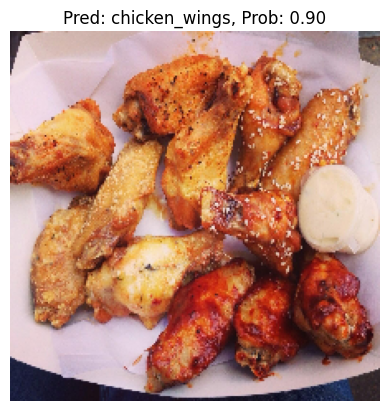

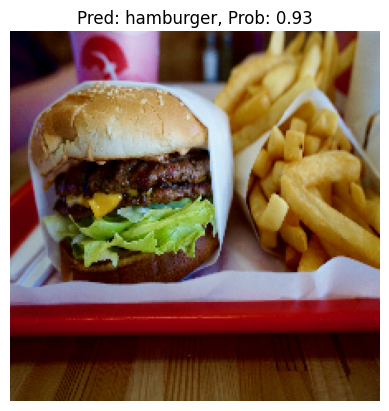

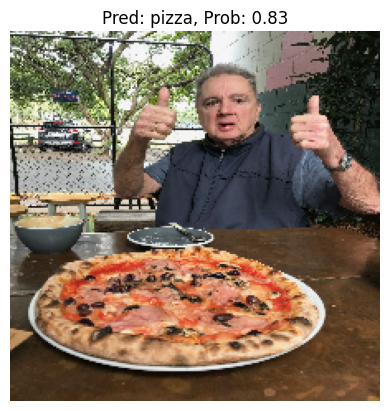

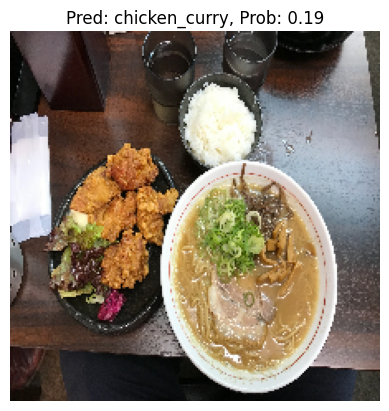

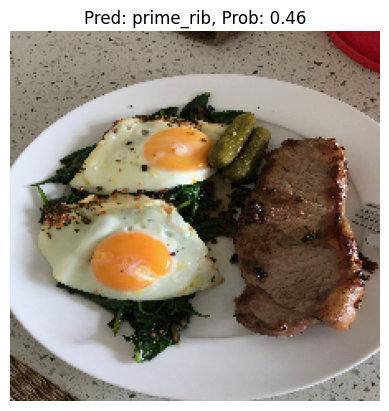

In [ ]:
# Make predictions on and plot custom food images
for img in custom_food_images:
    img = load_and_prep_image(img, scale = False) # Don't need to scale for our EfficientNetB0 model
    pred_prob = model.predict(tf.expand_dims(img, axis = 0)) # Make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
    pred_class = class_names[pred_prob.argmax()] # Get the index with the highest prediction probability
    # Plot the appropriate information
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f'Pred: {pred_class}, Prob: {pred_prob.max():.2f}')
    plt.axis(False)